# First Step on Deep Learning Using Tensorflow

## 数据的解压/pickle/shuffle/pickle,最后做出训练集/测试集/验证集，并保存为pickle格式

上一层网络全部链接到下一层的网络，称作 fully-connected（全连接） 网络。

在本次作业中，我们将使用经典数据集 mnist的升级版，notMNIST构建神经网络进行图像分类。

本次作业，你需要完成1, 2, 3三个联系。 能够掌握：

1. 数据预处理的知识
2. 深度学习程序的构建方式
3. 训练集、测试集、验证集
4. 神经网络的基础知识
5. 图计算网络
6. 正则化

## Assignment 1
The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the notMNIST dataset to be used with python experiments. This dataset is designed to look like the classic MNIST dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

### 导入模块

In [ ]:
# These are all the modules we'll be using later. Make sure you can import them

from __future__ import print_function
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
%matplotlib inline

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labeled examples. Given these sizes, it should be possible to train models quickly on any machine.

### 下载notMNIST数据集

In [21]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_directory = 'D:/code_project/datasource/notMNIST' #store data path

def download_progress_hook(count, blockSize, totalSize):
    """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
    global last_percent_reported
    percent = int(count * blockSize *100/totalSize)
    
    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write("%s%%" %percent)
            sys.stdout.flush()
        else:
            sys.stdout.write(".")
            sys.stdout.flush()
            
        last_percent_reported = percent

        

def maybe_download(filename, expected_bytes, force=False):
    """Download a file if not present, and make sure it's the right size."""
    
    dest_filename = os.path.join(data_directory, filename)
    if force or not os.path.exists(dest_filename):
        print('Attempting to download: ',filename)
        filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
        print('\n Download complete!')
    
    statinfo = os.stat(dest_filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', dest_filename)
    else:
        raise Exception('Failed to verify' + dest_filename + '. Can you get to it with a browser?')
    
    return dest_filename


train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download("notMNIST_small.tar.gz", 8458043)

Found and verified D:/code_project/datasource/notMNIST\notMNIST_large.tar.gz
Attempting to download:  notMNIST_small.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
 Download complete!
Found and verified D:/code_project/datasource/notMNIST\notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file. This should give you a set of directories, labeled A through J.

### 解压缩数据集

In [24]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
    root = os.path.splitext(os.path.splitext(filename)[0])[0] #splitext会将文件名和拓展名分开，这里是删除 .tar.gz后缀
    if os.path.isdir(root) and not force:
        # You may override by setting force=True.
        print('%s already present - skipping extraction of %s' %(root, filename))
    else:
        print('extracting data for %s. This may take a while. Please wait.' %root)
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall(data_directory)
        tar.close()
    
    data_folders = [
        os.path.join(root, d) for d in sorted(os.listdir(root)) 
        if os.path.isdir(os.path.join(root,d))
    ]
    
    if len(data_folders) != num_classes:
        raise Exception(
        'Excepted %d folders, one per class. Found %d instead.' %(num_classes, len(data_folders))
        )
    
    print(data_folders)
    return data_folders

train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

D:/code_project/datasource/notMNIST\notMNIST_large already present - skipping extraction of D:/code_project/datasource/notMNIST\notMNIST_large.tar.gz
['D:/code_project/datasource/notMNIST\\notMNIST_large\\A', 'D:/code_project/datasource/notMNIST\\notMNIST_large\\B', 'D:/code_project/datasource/notMNIST\\notMNIST_large\\C', 'D:/code_project/datasource/notMNIST\\notMNIST_large\\D', 'D:/code_project/datasource/notMNIST\\notMNIST_large\\E', 'D:/code_project/datasource/notMNIST\\notMNIST_large\\F', 'D:/code_project/datasource/notMNIST\\notMNIST_large\\G', 'D:/code_project/datasource/notMNIST\\notMNIST_large\\H', 'D:/code_project/datasource/notMNIST\\notMNIST_large\\I', 'D:/code_project/datasource/notMNIST\\notMNIST_large\\J']
extracting data for D:/code_project/datasource/notMNIST\notMNIST_small. This may take a while. Please wait.
['D:/code_project/datasource/notMNIST\\notMNIST_small\\A', 'D:/code_project/datasource/notMNIST\\notMNIST_small\\B', 'D:/code_project/datasource/notMNIST\\notMNI

# Problem 1

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.



Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road.

A few images might not be readable, we'll just skip them.

### 数据量太大无法全部读取到内存中，分批读取数据

显示一个图片样本

#### 将这个字母下的所有图片转换为一个三维数组

In [175]:
image_size = 28  #Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel

def load_letter(folder, min_num_image):
    """
    Load the data for a single letter label.
    """
    image_files =os.listdir(folder)
    dataset = np.ndarray(shape=(len(image_files), image_size, image_size), dtype=np.float32)
    print(folder)
    num_image = 0
    for image in image_files:
        image_file = os.path.join(folder, image)
        try:
            image_data = (imageio.imread(image_file).astype(float) - pixel_depth/2) / pixel_depth
            if image_data.shape != (image_size, image_size):
                raise Exception('Unexpected image shape: %s' %str(image_data.shape))
            
            dataset[num_image,:,:] = image_data
            num_image = num_image + 1
        
        except (IOError, ValueError) as e:
            print('Could not read:', image_file, ':', e, '-it\'s ok, skipping.')
    
    dataset = dataset[0:num_image,:,:]
    if num_image < min_num_image:
        raise Exception('Many fewer images than excepted: %d < %d' %(num_image, min_num_image))
    
    print('Full dataset tensor:', dataset.shape)
    print('Mean:', np.mean(dataset))
    print('Standard deviation:', np.std(dataset))
    return dataset

#### pickle化数据

In [176]:
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
    """
    将所有的图片按照字母类别转换格式，每种字母转换为1个pickle类型
    """
    dataset_names = []
    for folder in data_folders:
        set_filename = folder + '.pickle'
        dataset_names.append(set_filename)
        if os.path.exists(set_filename) and not force:
            # You may override by setting force=True
            print('%s already present - Skipping pickling.' % set_filename)
        else:
            print('Pickling %s.' % set_filename)
            dataset = load_letter(folder, min_num_images_per_class)
            try:
                with open(set_filename,'wb') as f:
                    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
            except Exception as e:
                print('Unalbe to save data to ', set_filename, ':', e)
    return dataset_names

In [177]:
train_datasets_name = maybe_pickle(train_folders, 45000)
test_datasets_name = maybe_pickle(test_folders,1800)

D:/code_project/datasource/notMNIST\notMNIST_large\A.pickle already present - Skipping pickling.
D:/code_project/datasource/notMNIST\notMNIST_large\B.pickle already present - Skipping pickling.
D:/code_project/datasource/notMNIST\notMNIST_large\C.pickle already present - Skipping pickling.
D:/code_project/datasource/notMNIST\notMNIST_large\D.pickle already present - Skipping pickling.
D:/code_project/datasource/notMNIST\notMNIST_large\E.pickle already present - Skipping pickling.
D:/code_project/datasource/notMNIST\notMNIST_large\F.pickle already present - Skipping pickling.
D:/code_project/datasource/notMNIST\notMNIST_large\G.pickle already present - Skipping pickling.
D:/code_project/datasource/notMNIST\notMNIST_large\H.pickle already present - Skipping pickling.
D:/code_project/datasource/notMNIST\notMNIST_large\I.pickle already present - Skipping pickling.
D:/code_project/datasource/notMNIST\notMNIST_large\J.pickle already present - Skipping pickling.
D:/code_project/datasource/not

In [181]:
train_datasets_name

['D:/code_project/datasource/notMNIST\\notMNIST_large\\A.pickle',
 'D:/code_project/datasource/notMNIST\\notMNIST_large\\B.pickle',
 'D:/code_project/datasource/notMNIST\\notMNIST_large\\C.pickle',
 'D:/code_project/datasource/notMNIST\\notMNIST_large\\D.pickle',
 'D:/code_project/datasource/notMNIST\\notMNIST_large\\E.pickle',
 'D:/code_project/datasource/notMNIST\\notMNIST_large\\F.pickle',
 'D:/code_project/datasource/notMNIST\\notMNIST_large\\G.pickle',
 'D:/code_project/datasource/notMNIST\\notMNIST_large\\H.pickle',
 'D:/code_project/datasource/notMNIST\\notMNIST_large\\I.pickle',
 'D:/code_project/datasource/notMNIST\\notMNIST_large\\J.pickle']

# Problem 2

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

#### 验证数据经过pickle之后是否还有效，即反pickle

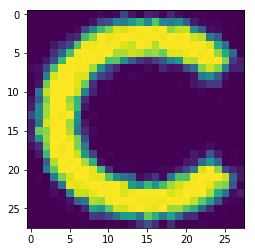

In [178]:
import matplotlib.pyplot as plt
%matplotlib inline

file = 'D:\\code_project\\datasource\\notMNIST\\notMNIST_small\\C.pickle'
with open(file,'rb') as f:
    letter_load = pickle.load(f)


plt.imshow(letter_load[0])

# Problem 3

Another check: we expect the data to be balanced across classes. Verify that.

Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune train_size as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

#### 根据计算机内存，设置合适的训练数据

In [184]:
def make_arrays(nb_rows, image_size):
    if nb_rows:
        dataset = np.ndarray(shape=(nb_rows, image_size, image_size), dtype=np.float32)
        labels = np.ndarray(shape=(nb_rows),dtype=np.int32)
    else:
        dataset, labels = None, None
    return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
    num_classes = len(pickle_files)
    valid_dataset, valid_labels = make_arrays(valid_size, image_size)
    train_dataset, train_labels = make_arrays(train_size, image_size)
    vsize_per_class = valid_size // num_classes
    tsize_per_class = train_size // num_classes
    
    start_v, start_t = 0, 0
    end_v, end_t = vsize_per_class, tsize_per_class
    end_l = vsize_per_class + tsize_per_class
    print('begin merging...')
    for label, pickle_file in enumerate(pickle_files):
        try:
            with open(pickle_file, 'rb') as f:
                letter_set = pickle.load(f)
                # let's shuffle the letters to have random validation and training set
                np.random.shuffle(letter_set)
                if valid_dataset is not None:
                    valid_letter = letter_set[:vsize_per_class, :, :]
                    valid_dataset[start_v:end_v, :, :] = valid_letter
                    valid_labels[start_v:end_v] = label
                    start_v += vsize_per_class
                    end_v += vsize_per_class
                print('label:',label)    
                train_letter = letter_set[vsize_per_class:end_l, :, :]
                train_dataset[start_t:end_t, :, :] = train_letter
                train_labels[start_t:end_t] = label
                start_t += tsize_per_class
                end_t += tsize_per_class
            
        except Exception as e:
            print('Unalbe to process data from', pickle_file, ':', e)
            raise
        
    return valid_dataset, valid_labels, train_dataset, train_labels

In [185]:
train_size = 2000
valid_size = 100
test_size = 100

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
    train_datasets_name, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets_name, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

begin merging...
label: 0
label: 1
label: 2
label: 3
label: 4
label: 5
label: 6
label: 7
label: 8
label: 9
begin merging...
label: 0
label: 1
label: 2
label: 3
label: 4
label: 5
label: 6
label: 7
label: 8
label: 9
Training: (2000, 28, 28) (2000,)
Validation: (100, 28, 28) (100,)
Testing: (100, 28, 28) (100,)



Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

#### 随机化数据

In [186]:
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation, :, :]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels

train_dataset, train_labels = randomize(train_dataset, train_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)

In [187]:
print(train_labels)
#print(np.random.permutation(train_labels.shape[0]))
type(train_dataset)
print(train_labels.shape)

[0 4 2 ... 6 2 3]
(2000,)


# Problem 4
Convince yourself that the data is still good after shuffling!

#### shuffle之后再次验证数据是否有效

Training: (2000, 28, 28) (2000,)
Validation: (100, 28, 28) (100,)
Testing: (100, 28, 28) (100,)


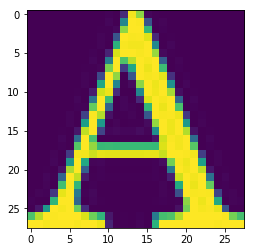

In [188]:
import matplotlib.pyplot as plt
%matplotlib inline

picture = train_dataset[0]
plt.imshow(picture)
print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

#### Finally, let's save the data for later reuse:
#### 保存shuffle之后的数据

In [190]:
pickle_file = os.path.join(data_directory, 'notMNIST.pickle')

try:
    f = open(pickle_file, 'wb')
    save = {
        'train_dataset': train_dataset,
        'train_labels': train_labels,
        'valid_dataset': valid_dataset,
        'valid_labels': valid_labels,
        'test_dataset': test_dataset,
        'test_labels': test_labels
    }
    
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

In [191]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 6908489


# Problem 5
By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it. Measure how much overlap there is between training, validation and test samples.

Optional questions:

What about near duplicates between datasets? (images that are almost identical)
Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.


#### 判断训练集/测试集/验证集的重叠程度

# Problem 6
Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

#### 在sklearn模型中将这些图片分类